## Capstone Project 1: Modelling Cycle Hire Network
### Part 3: Feature Engineering

<b>In part 3, we will contine our work in Part 1 in cleaning up the data and selecting the right features for our model.

In [30]:
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta

In [31]:
#download cleaned cycle hire data
cycle_df = pd.read_csv('cycle_df_weather.csv', parse_dates=[0, 1, 3])

<b>We want to use our model to predict the next-day demand at each station. We need to first reduce our observations to be a daily aggregation, then include more predictor variables such as rides count from day before and 7 day moving average for the duration. 

In [32]:
# drop non useful columns
features_df = cycle_df.drop(columns=['Start Date', 'End Date', 'StartStation Name', 'EndStation Name',
                                    'EndStation Id', 'hour'])

# aggregate data by day and station 
aggfunc = {'Duration(mins)' : 'mean', 'Day' : 'max', 'day_code' : 'max', 'Temperature' : 'mean', 'Wind Speed' : 'mean',
           'w_cond_Bad weather' : 'mean', 'w_cond_Good weather' : 'mean', 'w_cond_OK weather' : 'mean', 
           'w_cond_Very bad weather' : 'mean', 'Bike Id': 'count'}

features_df = features_df.groupby(['StartStation Id', 'Date']).agg(aggfunc).rename(columns={'Bike Id' : 'Count'})

# transform day codes into binary codes 
features_df['day_code'] = features_df['day_code'].replace({'PH' : 0, 'WD' : 0, 'W': 1})

<b>Before computing the rides count for the day before and 7 day rolling average for duration, we need to first fill in values for dates not found in the observations i.e. dates where no one hired a cycle. We can do this by creating a new index that spans all the stations for all the dates in the dataset and use reindexing to fill the days with 0 for number of rides and 0 for duration of rides.

In [33]:
#creating new index for all dates
date_range = np.tile(pd.date_range(start = features_df.index.min()[1], end= features_df.index.max()[1]), 
             features_df.index.max()[0])
num_range = np.repeat((np.array(list(range(features_df.index.max()[0]))) + 1), 
               (features_df.index.max()[1] - features_df.index.min()[1]).days + 1) 
new_index = list(zip(num_range, date_range))

new_index_df = features_df[['Duration(mins)', 'Count']].reindex(new_index).fillna(0)

#adding new features: day before count and 7 day rolling duration average
new_index_df['day_bf_count'] = new_index_df['Count'].groupby(level=0).shift()
new_index_df['7d_rolling_dur'] = new_index_df['Duration(mins)'].groupby(level=0).apply(lambda x: x.rolling(window=7).mean())

In [34]:
features_df['day_bf_count'] = new_index_df[new_index_df['Count'] != 0]['day_bf_count']
features_df['7d_rolling_dur'] = new_index_df[new_index_df['Count'] != 0]['7d_rolling_dur']

<b>Another useful information might be the number of rides that end at the specific station. This way we can see if there is a demand-supply mismatch.

In [35]:
end_station_num = cycle_df.groupby(['EndStation Id', 'Date']).count()['Bike Id']
end_station_num = end_station_num.rename_axis(index={"EndStation Id":"StartStation Id"})
end_station_num = end_station_num.reindex(new_index).fillna(0).to_frame()

end_station_num['day_bf_count_end'] = end_station_num.groupby(level=0).shift()
features_df = features_df.merge(end_station_num, how='left', left_index=True, right_on=['StartStation Id', 'Date']).rename(columns={'Bike Id':'count_end'})

In [36]:
new_col_names = ['Day', 'day_code', 'day_bf_count', 'day_bf_count_end', '7d_rolling_dur', 'Temperature', 'Wind Speed',
                'w_cond_Good weather', 'w_cond_OK weather', 'w_cond_Bad weather', 'w_cond_Very bad weather']
Y = features_df[['Duration(mins)', 'Count', 'count_end']]
features_df = features_df.drop(columns=['Duration(mins)', 'Count', 'count_end']).reindex(columns=new_col_names)

features_df.head()

Day  day_code  day_bf_count  day_bf_count_end  \
StartStation Id Date                                                        
1               2019-06-01    5         1           NaN               NaN   
                2019-06-02    6         0          16.0              14.0   
                2019-06-03    0         1          34.0              22.0   
                2019-06-04    1         1          23.0              13.0   
                2019-06-05    2         1          31.0              13.0   

                            7d_rolling_dur  Temperature  Wind Speed  \
StartStation Id Date                                                  
1               2019-06-01             NaN    21.812500   15.562500   
                2019-06-02             NaN    24.352941   27.588235   
                2019-06-03             NaN    17.043478   23.391304   
                2019-06-04             NaN    15.677419   12.000000   
                2019-06-05             NaN    15.300000   19.650000   

                            w_cond_Good weather  w_cond_OK weather  \
StartStation Id Date                                                 
1               2019-06-01             1.000000           0.000000   
                2019-06-02             1.000000           0.000000   
                2019-06-03             1.000000           0.000000   
                2019-06-04             0.741935           0.258065   
                2019-06-05             1.000000           0.000000   

                            w_cond_Bad weather  w_cond_Very bad weather  
StartStation Id Date                                                     
1               2019-06-01                 0.0                      0.0  
                2019-06-02                 0.0                      0.0  
                2019-06-03                 0.0                      0.0  
                2019-06-04                 0.0                      0.0  
                2019-06-05                 0.0                      0.0

In [37]:
features_df.rename(columns={'day_code':'is_weekday', 'Temperature':'temperature', 'Wind Speed':'wind_speed', 
                           'w_cond_Good weather':'good_weather', 'w_cond_OK weather':'ok_weather',
                           'w_cond_Bad weather':'bad_weather', 'w_cond_Very bad weather':'very_bad_weather',
                           'Day':'day_no', 'day_bf_count':'start_count_day_bf', 'day_bf_count_end':'end_count_day_bf'},
                  inplace=True)

In [38]:
features_df.head()

day_no  is_weekday  start_count_day_bf  \
StartStation Id Date                                                 
1               2019-06-01       5           1                 NaN   
                2019-06-02       6           0                16.0   
                2019-06-03       0           1                34.0   
                2019-06-04       1           1                23.0   
                2019-06-05       2           1                31.0   

                            end_count_day_bf  7d_rolling_dur  temperature  \
StartStation Id Date                                                        
1               2019-06-01               NaN             NaN    21.812500   
                2019-06-02              14.0             NaN    24.352941   
                2019-06-03              22.0             NaN    17.043478   
                2019-06-04              13.0             NaN    15.677419   
                2019-06-05              13.0             NaN    15.300000   

                            wind_speed  good_weather  ok_weather  bad_weather  \
StartStation Id Date                                                            
1               2019-06-01   15.562500      1.000000    0.000000          0.0   
                2019-06-02   27.588235      1.000000    0.000000          0.0   
                2019-06-03   23.391304      1.000000    0.000000          0.0   
                2019-06-04   12.000000      0.741935    0.258065          0.0   
                2019-06-05   19.650000      1.000000    0.000000          0.0   

                            very_bad_weather  
StartStation Id Date                          
1               2019-06-01               0.0  
                2019-06-02               0.0  
                2019-06-03               0.0  
                2019-06-04               0.0  
                2019-06-05               0.0

### Part 4: Statistical Analysis

In [3]:
import pymc3 as pm
import theano.tensor as tt
from matplotlib import pyplot as plt
import matplotlib.dates as mdates

<b><div class="alert alert-block alert-info">Q1. How does the frequency of hiring bikes change in a day?</div>

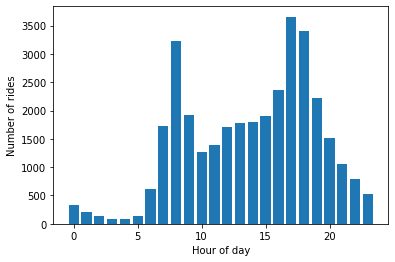

In [6]:
count_data = cycle_df.groupby(['Date', 'hour']).count()['Bike Id'].groupby('hour').mean()
plt.bar(count_data.index, count_data.values)
plt.xlabel('Hour of day')
plt.ylabel('Number of rides')
plt.show()

In [32]:
count_data = count_data.loc[0:19]

with pm.Model() as model:
    alpha = 1.0/count_data.values.mean()
    lambda_1 = pm.Exponential("lambda_1", alpha)
    lambda_2 = pm.Exponential("lambda_2", alpha)
    lambda_3 = pm.Exponential("lambda_3", alpha)
    
    tau_1 = pm.DiscreteUniform("tau_1", lower=0, upper=len(count_data) - 1)
    tau_2 = pm.DiscreteUniform("tau_2", lower=tau_1, upper=len(count_data) - 1)
    
    idx = np.arange(len(count_data)) 
    lambda_ = pm.math.switch(tau_2 > idx, pm.math.switch(tau_1 > idx, lambda_1, lambda_2), lambda_3)
    
    observation = pm.Poisson("obs", lambda_, observed=count_data.values)

In [33]:
with model:
    step = pm.Metropolis()
    trace = pm.sample(10000, tune=5000,step=step)

lambda_1_samples = trace['lambda_1']
lambda_2_samples = trace['lambda_2']
lambda_3_samples = trace['lambda_3']
tau_samples = trace['tau_1']
tau_2_samples = trace['tau_2']

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau_2]
>Metropolis: [tau_1]
>Metropolis: [lambda_3]
>Metropolis: [lambda_2]
>Metropolis: [lambda_1]
Sampling 4 chains: 100%|████████████| 60000/60000 [00:36<00:00, 1648.91draws/s]
The number of effective samples is smaller than 25% for some parameters.


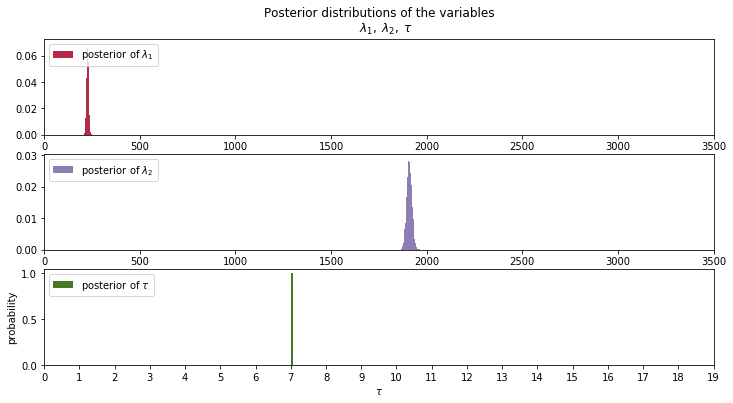

In [36]:
def plot_tau_dist(lambda_1, lambda_2, tau, n_tau, xlim, fig_size=(12, 6)):
    
    plt.figure(figsize=fig_size)
    ax = plt.subplot(311)
    plt.hist(lambda_1, bins=30, alpha=0.85,
             label="posterior of $\lambda_1$", color="#A60628", density=True)
    plt.legend(loc="upper left")
    plt.title(r"""Posterior distributions of the variables
    $\lambda_1,\;\lambda_2,\;\tau$""")
    plt.xlabel("$\lambda_1$ value")
    plt.xlim(xlim)

    ax = plt.subplot(312)
    plt.hist(lambda_2, bins=30, alpha=0.85,
             label="posterior of $\lambda_2$", color="#7A68A6", density=True)
    plt.legend(loc="upper left")
    plt.xlabel("$\lambda_2$ value")
    plt.xlim(xlim)

    plt.subplot(313)
    w = 1.0 / tau.shape[0] * np.ones_like(tau)
    plt.hist(tau, bins=n_tau, alpha=1,
             label=r"posterior of $\tau$",
             color="#467821", weights=w, rwidth=2.)
    plt.xticks(np.arange(n_tau))

    plt.legend(loc="upper left")
    plt.xlabel(r"$\tau$")
    plt.ylabel("probability")

plot_tau_dist(lambda_1_samples, lambda_2_samples, tau_samples, len(count_data), [0, 3500])

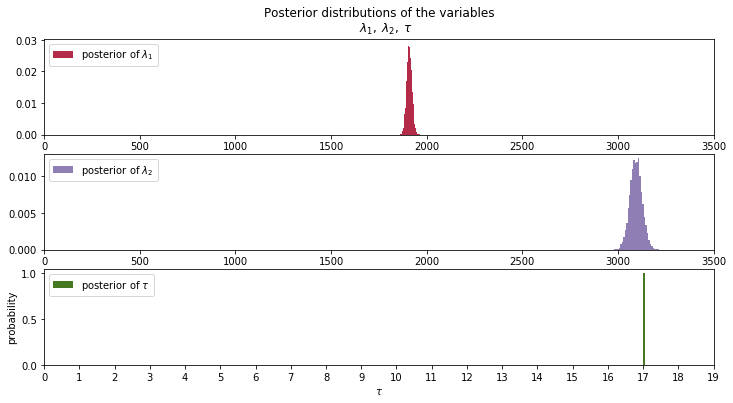

In [37]:
plot_tau_dist(lambda_2_samples, lambda_3_samples, tau_2_samples, len(count_data), [0, 3500])

<b>The model shows that there is a close to 100% probability that the ride count changes at 7am and  at 5pm. The posterior distributions of the 2 $\lambda$s are very distinct indicating there is a significant change in ridership after 7am and after 5pm with the mean of $\lambda_1$ at around 250, the mean of $\lambda_2$ close to 2000 and the mean of $\lambda_3$ close to 3000.

<b><div class="alert alert-block alert-info">Q2. Did the frequency of bike hiring change during significantly during this time period?</div>

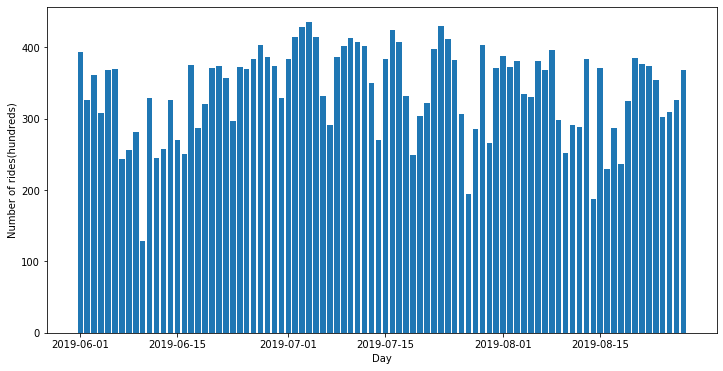

In [110]:
count_data = cycle_df.groupby(['Date']).count()['Bike Id']/100
plt.figure(figsize=(12,6))
plt.bar(count_data.index, count_data.values)
plt.format_xdata = mdates.DateFormatter('%Y-%m-%d')
plt.xlabel('Day')
plt.ylabel('Number of rides(hundreds)')
plt.show()

In [111]:
with pm.Model() as model:
    alpha = 1.0/count_data.values.mean()
    lambda_1 = pm.Exponential("lambda_1", alpha)
    lambda_2 = pm.Exponential("lambda_2", alpha)
    
    tau = pm.DiscreteUniform("tau", lower=0, upper=len(count_data) - 1)
    
    idx = np.arange(len(count_data)) 
    lambda_ = pm.math.switch(tau > idx, lambda_1, lambda_2)
    
    observation = pm.Poisson("obs", lambda_, observed=count_data.values)

with model:
    step = pm.Metropolis()
    trace = pm.sample(10000, tune=5000,step=step)

lambda_1_samples = trace['lambda_1']
lambda_2_samples = trace['lambda_2']
tau_samples = trace['tau']

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [lambda_2]
>Metropolis: [lambda_1]
Sampling 4 chains: 100%|████████████| 60000/60000 [00:29<00:00, 2011.15draws/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


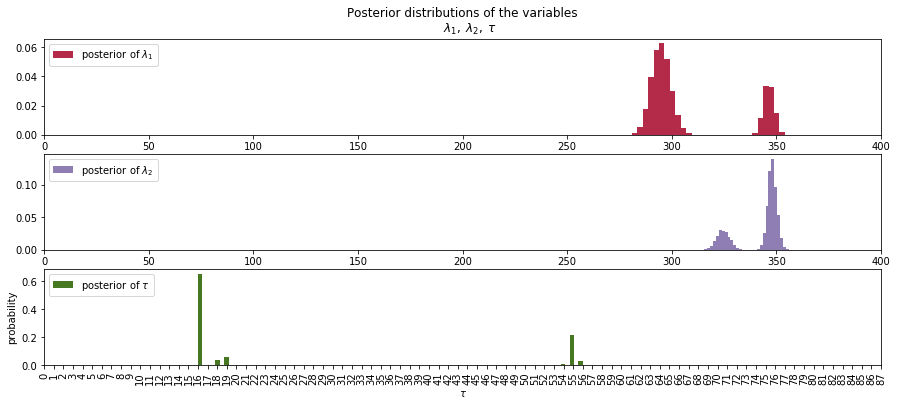

In [112]:
plot_tau_dist(lambda_1_samples, lambda_2_samples, tau_samples, len(count_data), [0, 400], (15, 6))
plt.xticks(rotation=90)
plt.show()

<b>The analysis shows no clear evidence of there being a significant change in ride hiring over the period. There is no distinct differences between $\lambda$s and the sampler did not converge.